# Real Estate Market Selection Model

In [1]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [2]:
df_train_test = pd.read_csv('df_train_test.csv')
df_validation = pd.read_csv('df_validation.csv')
df_score = pd.read_csv('df_score.csv')

In [3]:
min_population = 0

print(df_train_test[df_train_test.population > min_population].shape[0]/df_train_test.shape[0])

df_train_test = df_train_test[df_train_test.population > min_population]
df_validation = df_validation[df_validation.population > min_population]
df_score = df_score[df_score.population > min_population]

1.0


#Breaking the test/train population into one group of FIPs the validation dataset into a different group of FIPs
#This will ensure that the validation dataset is both out of sample and out of time from the test/train dataset

fips_test_train = df_train_test.fips.sample(frac=0.7, replace=False, random_state=1)
df_train_test = df_train_test[df_train_test.fips.isin(fips_test_train.values)]
df_validation = df_validation[~df_validation.fips.isin(fips_test_train.values)]

In [4]:
df_train_test.columns

Index(['fips', 'zhvi_weighted_future_growth', '  Construction_growth',
       '  Finance, insurance, real estate, rental, and leasing_growth',
       '  Manufacturing_growth',
       '  Mining, quarrying, and oil and gas extraction_growth',
       '  Retail trade_growth', ' Private industries_growth',
       'All industry total_growth',
       'Government and government enterprises_growth', 'population_growth',
       'labor_force_growth', 'employed_growth', 'unemployed_growth',
       'unemployment_rate_growth', 'zhvi_weighted_growth', 'county',
       'Census Population 2010', 'zhvi_weighted', ' Private industries',
       'All industry total', 'Government and government enterprises',
       'population', 'labor_force', 'employed', 'unemployed',
       'unemployment_rate', '  Construction_0_yoy__growth',
       '  Finance, insurance, real estate, rental, and leasing_0_yoy__growth',
       '  Manufacturing_0_yoy__growth',
       '  Mining, quarrying, and oil and gas extraction_0_yoy__

In [5]:
target = 'zhvi_weighted_future_growth'
features = df_train_test.drop(['fips','zhvi_weighted_future_growth','county', 'Census Population 2010',], axis=1).columns

In [6]:
X, y = df_train_test[features],df_train_test[target]
X_val, y_val = df_validation[features],df_validation[target]
X_score = df_score[features]

In [7]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [8]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 3, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=100,
                    num_boost_round=1000,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

#cv_results.head()
print((cv_results["test-rmse-mean"]).tail(1))

157    0.118953
Name: test-rmse-mean, dtype: float64


In [9]:
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0, random_state=123)


xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 3, alpha = 5, n_estimators = 100)

xg_reg.fit(X,y) #fit on all data

XGBRegressor(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=5,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [10]:
# check RMSE on validation dataset (out of time period, in sample)
preds = xg_reg.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.100827


In [11]:
df_validation.shape[0]

2075

In [12]:
df_validation["predicted_3yr_appreciation"] = preds
df_validation["y_val"] = y_val
df_validation['pred_deciles'] = pd.qcut(df_validation['predicted_3yr_appreciation'], q=20, precision=0)

In [13]:
bin_lables = [1, 2, 3, 4, 5]
quantiles = [0, .25, .5, .75, 0.98, 1.]
df_validation["appreciation_bin"], bin_edges = pd.qcut(df_validation['zhvi_weighted_growth'], q= quantiles, precision=0, labels = bin_lables, retbins = True)
#df_validation['appreciation_bin'] = pd.cut(df_validation['zhvi_weighted_growth'], bins=bin_edges, labels=bin_lables)
df_validation["pred_appreciation_bin"], bin_edges = pd.qcut(df_validation['predicted_3yr_appreciation'], q= quantiles, precision=0, labels = bin_lables, retbins = True)
#df_validation["pred_appreciation_bin"] = pd.cut(df_validation['predicted_3yr_appreciation'], bins=bin_edges, labels=bin_lables)


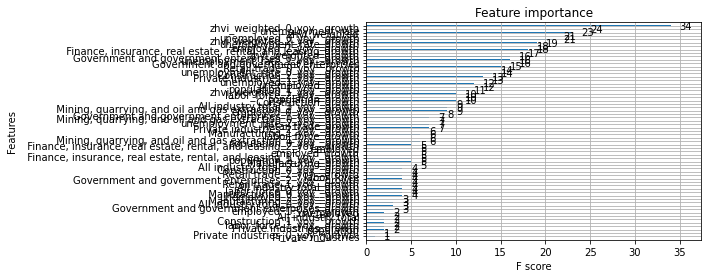

In [14]:
import matplotlib.pyplot as plt

xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [20,10]
plt.show()

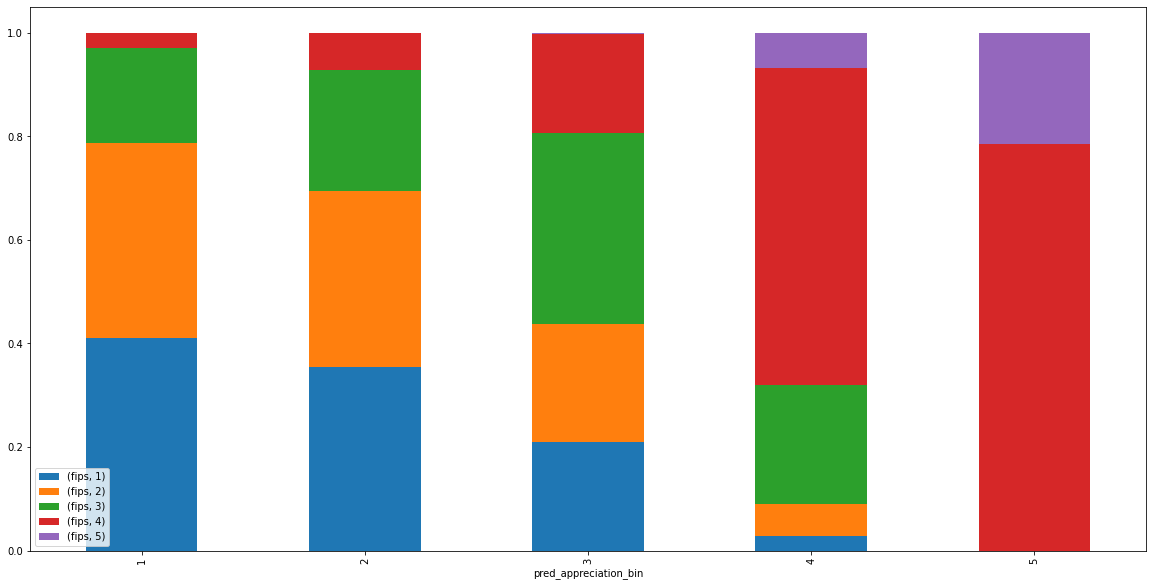

In [15]:
min_population = 1000
min_zhvi = 0
tps = df_validation[(df_validation.population > min_population)&(df_validation.zhvi_weighted > min_zhvi)].pivot_table(values=['fips'], 
                      index='pred_appreciation_bin',
                      columns='appreciation_bin',
                      aggfunc='count')

tps = tps.div(tps.sum(1), axis=0)
tps.plot(kind='bar', stacked=True).legend(loc='lower left')
plt.rcParams['figure.figsize'] = [10, 10]

<AxesSubplot:xlabel='predicted_3yr_appreciation', ylabel='y_val'>

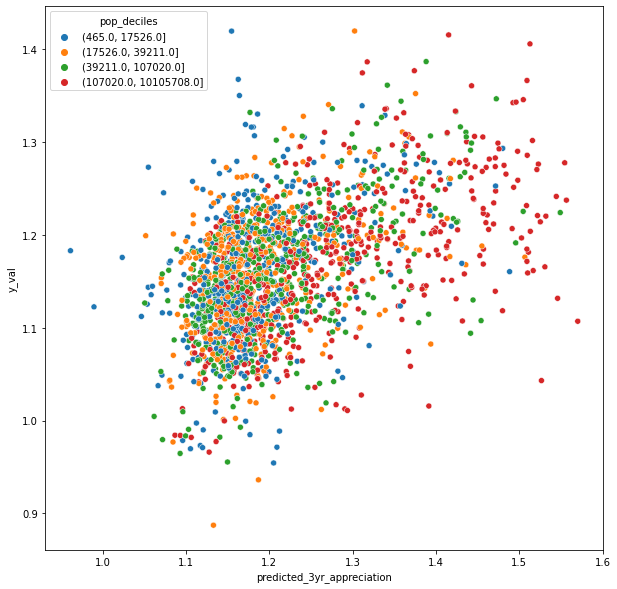

In [16]:
df_validation['pop_deciles'] = pd.qcut(df_validation['population'], q=4, precision=0)

import seaborn as sns
sns.scatterplot(data=df_validation, x="predicted_3yr_appreciation", y="y_val", hue="pop_deciles")


Text(0.5, 1.0, 'Actual vs Predicted Appreciation')

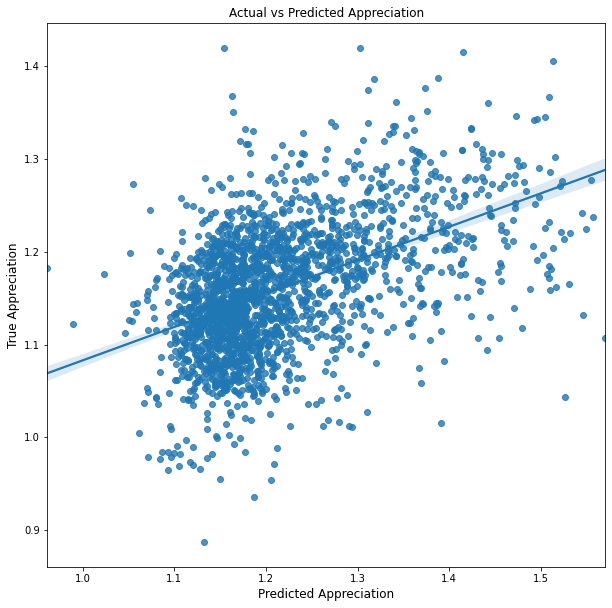

In [17]:
import seaborn as sns
p = sns.regplot(x = preds, y= y_val , )
p.set_xlabel("Predicted Appreciation", fontsize = 12)
p.set_ylabel("True Appreciation", fontsize = 12)
p.set_title("Actual vs Predicted Appreciation")

Text(0.5, 1.0, 'Predicted vs Actual 3YR Appreciation for Validation Dataset')

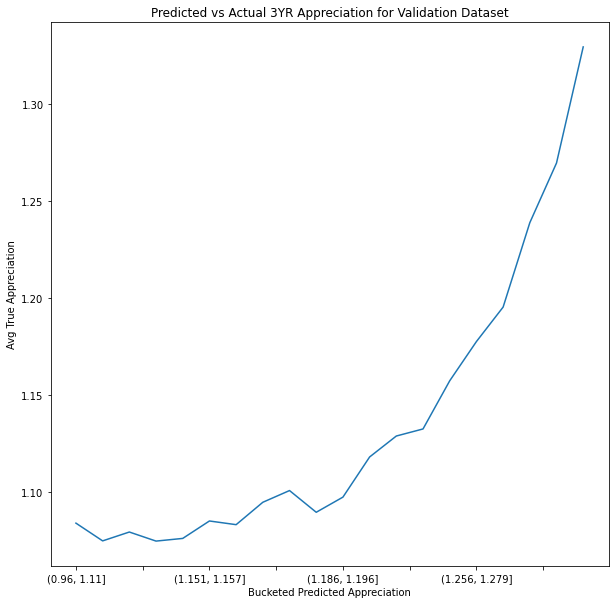

In [18]:

df_validation['pred_deciles'] = pd.qcut(df_validation['predicted_3yr_appreciation'], q=20, precision=0)
ax = df_validation.groupby('pred_deciles').zhvi_weighted_growth.mean().plot()
ax.set_xlabel("Bucketed Predicted Appreciation")
ax.set_ylabel("Avg True Appreciation")
ax.set_title("Predicted vs Actual 3YR Appreciation for Validation Dataset")

Text(0.5, 1.0, 'Std of Actual Appreciation vs Predicted Appreciation')

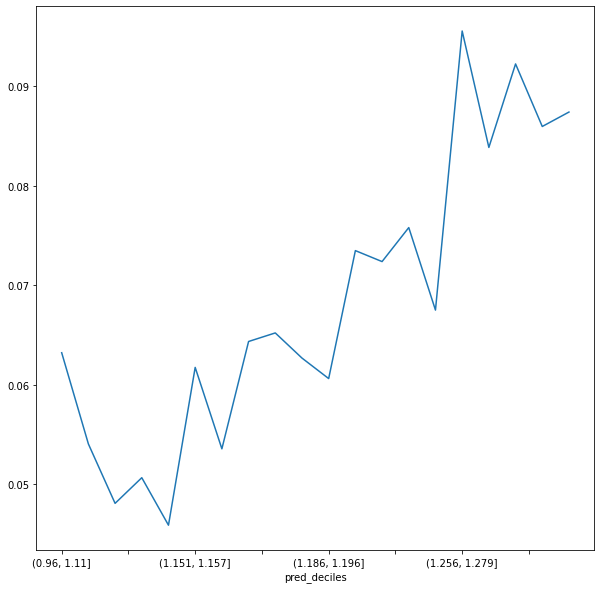

In [19]:
df_validation.groupby('pred_deciles').zhvi_weighted_growth.std().plot()
ax.set_xlabel("Bucketed Predicted Appreciation")
ax.set_ylabel("Standard Deviation in Actuals")
ax.set_title("Std of Actual Appreciation vs Predicted Appreciation")

In [20]:
score_preds = xg_reg.predict(X_score)

In [21]:
score_preds

array([1.1870173, 1.4023428, 1.2387878, ..., 1.1633326, 1.2401036,
       1.243808 ], dtype=float32)

In [22]:
df_score["predicted_3yr_appreciation"] = score_preds

In [23]:
df_score = df_score.sort_values(by= 'predicted_3yr_appreciation', ascending=False)

In [24]:
df_score.columns

Index(['fips', '  Construction_growth',
       '  Finance, insurance, real estate, rental, and leasing_growth',
       '  Manufacturing_growth',
       '  Mining, quarrying, and oil and gas extraction_growth',
       '  Retail trade_growth', ' Private industries_growth',
       'All industry total_growth',
       'Government and government enterprises_growth', 'population_growth',
       'labor_force_growth', 'employed_growth', 'unemployed_growth',
       'unemployment_rate_growth', 'zhvi_weighted_growth', 'county',
       'Census Population 2010', 'zhvi_weighted', ' Private industries',
       'All industry total', 'Government and government enterprises',
       'population', 'labor_force', 'employed', 'unemployed',
       'unemployment_rate', '  Construction_0_yoy__growth',
       '  Finance, insurance, real estate, rental, and leasing_0_yoy__growth',
       '  Manufacturing_0_yoy__growth',
       '  Mining, quarrying, and oil and gas extraction_0_yoy__growth',
       '  Retail trade

In [25]:

df_score[["county","zhvi_weighted","population_growth","population","All industry total_growth","unemployment_rate","unemployment_rate_growth","predicted_3yr_appreciation"]].head(30)


,county,zhvi_weighted,population_growth,population,All industry total_growth,unemployment_rate,unemployment_rate_growth,predicted_3yr_appreciation
344,"Barrow, GA",225600.406286,1.081039,83240,1.232177,2.9,0.604167,1.580963
415,"Jackson, GA",208174.770734,1.121670,72977,1.228664,2.7,0.627907,1.570570
504,"Bonneville, ID",221882.260884,1.061935,119062,1.244403,2.3,0.741935,1.548612
463,"Spalding, GA",186626.636138,1.033418,66703,1.147132,4.1,0.585714,1.537009
1867,"Davis, UT",338340.989123,1.042466,355481,1.228354,2.4,0.774194,1.534133
508,"Elmore, ID",384374.000000,1.052569,27511,1.167495,3.1,0.775000,1.532341
445,"Oconee, GA",208713.509073,1.090742,40280,1.284056,2.6,0.634146,1.532252
1849,"Parker, TX",241831.576840,1.107865,142878,1.159970,2.9,0.707317,1.527373
1195,"Carson City (Independent City), NV",344113.033258,1.032670,55916,1.202808,3.9,0.629032,1.526925
1871,"Weber, UT",282532.555372,1.052935,260213,1.205804,2.9,0.783784,1.522268


In [26]:
df_score[["fips","county","zhvi_weighted","population_growth","population","All industry total_growth","unemployment_rate","unemployment_rate_growth","predicted_3yr_appreciation"]].to_csv('predicted_future_appreciation.csv')